### Подготовка исходных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка исходного датафрейма

df = pd.read_csv('train.csv')
data = df.copy()
df1 = pd.read_csv('test.csv')
test = df1.copy()

In [3]:
# Функция обработки выбросов тренировочного датасета

def prepare_data(data):
    # Правим выбросы Rooms
    data.loc[data['Rooms']==10, 'Rooms'] = 2
    data.loc[data['Rooms']==19, 'Rooms'] = 1
    data.loc[data['Rooms']==6, 'Rooms'] = 2
    data.loc[data['Id']==3159, 'Rooms'] = 1
    
    # Правим выбросы Square
    data.loc[data['Id']==28, 'Square'] = data.loc[data['Rooms']==2, 'Square'].mean()
    data.loc[data['Id']==2307, 'Square'] = data.loc[data['Rooms']==1, 'Square'].mean()
    data.loc[data['Id']==11602, 'Square'] = data.loc[data['Rooms']==2, 'Square'].mean()
    data.loc[data['Id']==3224, 'Square'] = data.loc[data['Rooms']==0, 'Square'].mean()
    data.loc[(data['Square']>data['Rooms']*45+45) & (data['Rooms']>0), 'Square'] = data['Rooms']*45 + 45
    data.loc[data['Square']<data['Rooms']*15, 'Square'] = data['Rooms']*15
    
    # Правим выбросы KitchenSquare
    data.loc[data['Id'] == 14656, 'KitchenSquare'] = data['KitchenSquare'].mean()
    data.loc[data['Id'] == 14679, 'KitchenSquare'] = data['KitchenSquare'].mean()
    data.loc[data['KitchenSquare'] > 20, 'KitchenSquare'] = data['KitchenSquare'].mean()
    
    # Правим выбросы LifeSquare
    data.loc[data['Id'] == 16550, 'LifeSquare'] = 60
    data.loc[data['LifeSquare'] > 250, 'LifeSquare'] = data['Square'] - data['KitchenSquare']
    data.loc[data['LifeSquare'] > data['Square'], 'LifeSquare'] = data['Square'] - data['KitchenSquare']
    
    # Правим выбросы Square
    data.loc[data['LifeSquare'] + data['KitchenSquare'] > data['Square'], 'Square'] = data['LifeSquare'] + data['KitchenSquare'] + 10
    
    # Правим выбросы LifeSquare
    data.loc[data['LifeSquare'] < data['Square']*0.4, 'LifeSquare'] = data['Square']*0.7
    data['LifeSquare'] = data['LifeSquare'].fillna(data['Square']-data['KitchenSquare'])
    
    # Правим выбросы HouseFloor
    data.loc[data['Floor'] > data['HouseFloor'], 'HouseFloor'] = data['Floor']
    data.loc[data['HouseFloor'] > 90, 'HouseFloor'] = data['Floor']
    
    # Правим выбросы HouseYear
    data.loc[data['Id']==10814, 'HouseYear'] = 2008
    data.loc[data['Id']==11607, 'HouseYear'] = 1968
    
    # Половины Healthcare_1 нет, поэтому удаляем
    data.drop('Healthcare_1', axis = 1, inplace = True)
    
    return data

In [4]:
# Функция обработки выбросов тестового датасета (по аналогии)

def prepare_test(test):
    test.loc[test['Id']==1435, 'Rooms'] = 2
    test.loc[(test['Square']>test['Rooms']*45+45) & (test['Rooms']>0), 'Square'] = test['Rooms']*45 + 45
    test.loc[test['Square']<test['Rooms']*15, 'Square'] = test['Rooms']*15
    test.loc[test['KitchenSquare'] > 20, 'KitchenSquare'] = test['KitchenSquare'].mean()
    test.loc[test['LifeSquare'] > test['Square'], 'LifeSquare'] = test['Square'] - test['KitchenSquare']
    test.loc[test['LifeSquare'] + test['KitchenSquare'] > test['Square'], 'Square'] = test['LifeSquare'] + test['KitchenSquare'] + 10
    test.loc[test['LifeSquare'] < test['Square']*0.4, 'LifeSquare'] = test['Square']*0.7
    test['LifeSquare'] = test['LifeSquare'].fillna(test['Square']-test['KitchenSquare'])
    test.loc[test['Floor'] > test['HouseFloor'], 'HouseFloor'] = test['Floor']
    
    return test

In [5]:
data = prepare_data(data)
test = prepare_test(test)

### Разбиение исходного датасета на тренировочный и валидационный и добавление новых признаков

In [6]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [7]:
# Полученный ниже датафрейм - содержит информацию о количестве предложений о продаже квартиры для каждого района

distr_info = train['DistrictId'].value_counts().reset_index().\
    rename(columns={'index':'DistrictId','DistrictId':'large_district'})

In [8]:
# Добавим в тренировочный датафрейм поле - цена на квадратный метр

train['price_per_m2'] = train['Price'] / train['Square']

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Добавляем в distr_info среднюю стоимость квадратного метра для каждого дистрикта

ppm_for_dist=train.groupby(['DistrictId'], as_index=False).agg({'price_per_m2':'mean'}).rename(columns={'price_per_m2':'ppm_for_dist'})
distr_info=pd.merge(distr_info, ppm_for_dist, on='DistrictId', how='left')

In [10]:
# Вычисляем среднюю цену на квадратный метр для каждого дистрикта

mean_ppm = ppm_for_dist['ppm_for_dist'].mean()
mean_ppm

4792.720178114966

In [11]:
# Функция добавления к датафрейму distr_info

def add_distr_info(df, distr_info, mean_ppm):
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    df['ppm_for_dist']=df['ppm_for_dist'].fillna(mean_ppm)
    return df

In [12]:
train = add_distr_info(train, distr_info, mean_ppm)

In [13]:
valid = add_distr_info(valid, distr_info, mean_ppm)

###  Кластеризация по HouseYear и DistrictId

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

In [15]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.loc[:,['HouseYear','DistrictId']])

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
model_year_dist = AgglomerativeClustering(n_clusters = 4)

In [17]:
train['cluster_year_distr'] = model_year_dist.fit_predict(train_scaled)

Text(0.5, 1.0, 'Train')

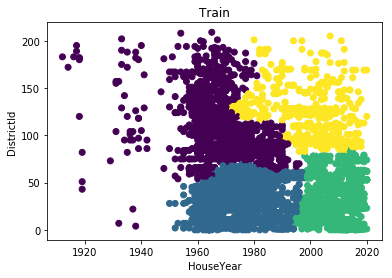

In [18]:
plt.scatter(train['HouseYear'], train['DistrictId'], c = train['cluster_year_distr'])
plt.xlabel('HouseYear')
plt.ylabel('DistrictId')
plt.title('Train')

In [19]:
knn_year_dist = KNeighborsClassifier(n_neighbors=4)

In [20]:
knn_year_dist.fit(train_scaled, train['cluster_year_distr'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

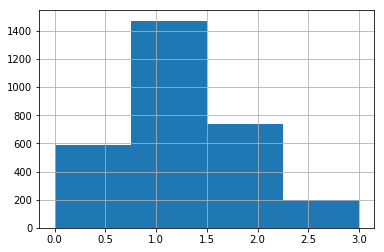

In [21]:
# Преобразуем валидационную выборку

valid_scaled = scaler.transform(valid.loc[:, ['HouseYear', 'DistrictId']])
valid['cluster_year_distr'] = knn_year_dist.predict(valid_scaled)
valid['cluster_year_distr'].hist(bins=4)

### Кластеризация по ppm_for_dist (средняя цена на кв м для района) и DistrictId

In [22]:
train_scaled = scaler.fit_transform(train.loc[:,['ppm_for_dist','DistrictId']])

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
model_ppm_dist = AgglomerativeClustering(n_clusters = 5)
train['cluster_dist_ppm'] = model_ppm_dist.fit_predict(train_scaled)

Text(0.5, 1.0, 'Train')

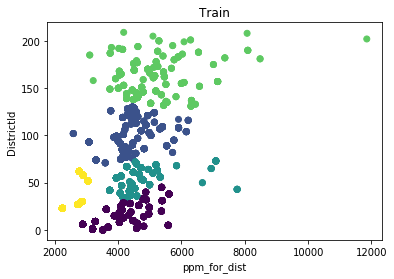

In [24]:
plt.scatter(train['ppm_for_dist'], train['DistrictId'], c = train['cluster_dist_ppm'])
plt.xlabel('ppm_for_dist')
plt.ylabel('DistrictId')
plt.title('Train')

In [25]:
knn_ppm_dist = KNeighborsClassifier(n_neighbors=5)
knn_ppm_dist.fit(train_scaled, train['cluster_dist_ppm'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [26]:
valid_scaled = scaler.transform(valid.loc[:, ['ppm_for_dist','DistrictId']])

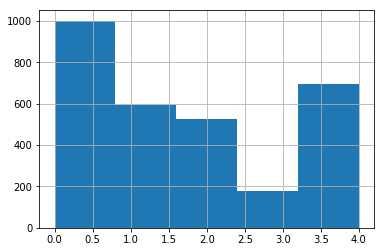

In [27]:
valid['cluster_dist_ppm'] = knn_ppm_dist.predict(valid_scaled)
valid['cluster_dist_ppm'].hist(bins=5)

In [28]:
# cluster_year_distr и cluster_dist_ppm надо преобразовать в дами-переменные

def dummies(df):
    df['cluster_year_distr']=df['cluster_year_distr'].astype(object)
    df['cluster_dist_ppm']=df['cluster_dist_ppm'].astype(object)
    df = pd.get_dummies(df)
    return df

In [29]:
train = dummies(train)
valid = dummies(valid)

### Предсказания на валидационной выборке 

In [30]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2

In [31]:
feats = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
        'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1',
        'Helthcare_2', 'Shops_1', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
       'ppm_for_dist', 'cluster_dist_ppm_0','cluster_dist_ppm_1','cluster_dist_ppm_2','cluster_dist_ppm_3','cluster_dist_ppm_4',
        'cluster_year_distr_0', 'cluster_year_distr_1', 'cluster_year_distr_2', 'cluster_year_distr_3']

model = RF(n_estimators = 1000, max_depth = 10, random_state = 42)
model.fit(train.loc[:, feats], train['Price'])
y_pred = model.predict(valid.loc[:, feats])
r2(valid['Price'], y_pred)

0.7145288820598859

### Предсказание на тестовой выборке 

In [32]:
# Добавим информацию в тестовую выборку о District: средняя цена на кв м и количество предложений о продаже

test = add_distr_info(test, distr_info, mean_ppm)

In [33]:
# Проведем классификацию для тестовой выборки

test_scaled = scaler.fit_transform(test.loc[:, ['HouseYear', 'DistrictId']])
test['cluster_year_distr'] = knn_year_dist.predict(test_scaled)
test_scaled = scaler.fit_transform(test.loc[:,['ppm_for_dist','DistrictId']])
test['cluster_dist_ppm'] = knn_ppm_dist.predict(test_scaled)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [34]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,large_district,ppm_for_dist,cluster_year_distr,cluster_dist_ppm
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,NaN,0,0,B,118.0,2891.162798,1,4
1,15856,74,2.0,69.263183,68.263183,1.0,6,6.0,1977,0.075779,...,1437,3,NaN,0,2,B,77.0,3303.114479,0,1
2,5480,190,1.0,15.000000,10.500000,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,4.0,8096.549882,0,3
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,NaN,3,3,B,66.0,4108.659766,2,2
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,NaN,0,0,A,574.0,2734.767489,2,4


In [35]:
# Преобразуем необходимые поля в дамми переменные

test = dummies(test)

In [36]:
test['Price'] = model.predict(test.loc[:, feats])

In [37]:
test.loc[:, ['Id', 'Price']].head()

,Id,Price
0,725,160590.800649
1,15856,226764.364546
2,5480,323928.416639
3,15664,318930.489084
4,14275,132459.223820


In [38]:
test.loc[:, ['Id', 'Price']].to_csv('DFedorov_predictions.csv', index=None)